# Experiment 1

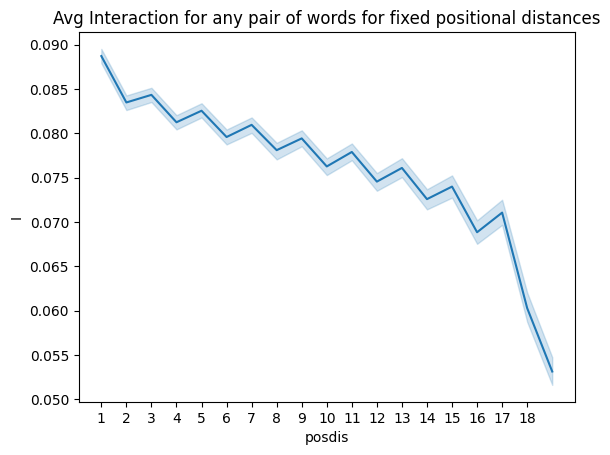

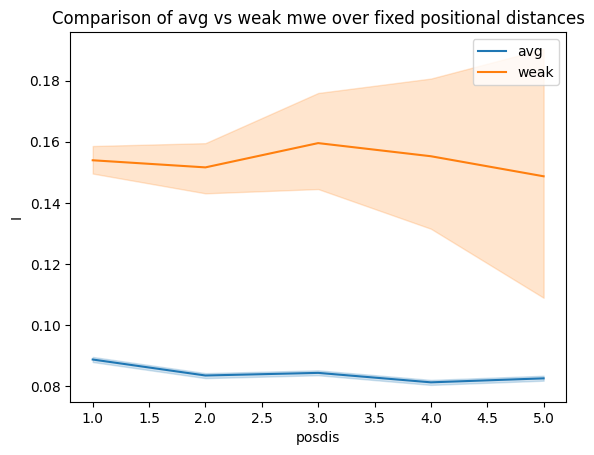

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mean(avg_path='average_distance.pkl', weak_path='weak_mwe_distance.pkl', strong_path='strong_mwe_distance.pkl'):
    avg_dist = pd.read_pickle(avg_path)
    avg_df = pd.DataFrame(avg_dist, columns = ['I', 'posdis', 'ignore'])
    avg_df['posdis'] = avg_df['posdis'].astype(int)
    g = sns.lineplot(data=avg_df, x="posdis", y="I")
    g.set_title('Avg Interaction for any pair of words for fixed positional distances')
    g.set(xticks=list(range(1,19)))
    plt.show()
    weak_mwe_distance = pd.read_pickle(weak_path)
    weak_mwe_df = pd.DataFrame(weak_mwe_distance, columns = ['I', 'posdis', 'ignore'])
    weak_mwe_df = weak_mwe_df[weak_mwe_df['posdis']!=0].copy()
    weak_mwe_df['count'] = weak_mwe_df.groupby('posdis')['I'].transform(lambda x : x.count())
    weak_mwe_df = weak_mwe_df[weak_mwe_df['count']>=50].copy()
    weak_mwe_df['posdis'] = weak_mwe_df['posdis'].astype(int)
    avg_df = avg_df[avg_df['posdis']<=weak_mwe_df['posdis'].max()].copy()

    fig, ax = plt.subplots()
    avg_line = sns.lineplot(data=avg_df, x="posdis", y="I", ax=ax, label='avg')
    weak_line = sns.lineplot(data=weak_mwe_df, x="posdis", y="I", ax=ax, label='weak')
    ax.set_title('Comparison of avg vs weak mwe over fixed positional distances')
    ax.legend()
    # ax.legend(labels=['avg','weak'])
    
    g.set(xticks=list(range(1,6)))
    # strong_mwe_distance = pd.read_pickle(strong_path)
    # strong_mwe_df = pd.DataFrame(strong_mwe_distance, columns = ['I', 'posdis', 'ignore'])
    # strong_mwe_df['count'] = strong_mwe_df.groupby('posdis')['I'].count()
    # strong_mwe_df = strong_mwe_df[strong_mwe_df['count']>=50].copy()
    plt.show()
plot_mean()

# Experiment 2

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



def f_df(path, method):
    abc = pd.read_pickle(path, compression='gzip')
    abc = abc.explode('tensor')
    abc[['method', 'tensor', 'token_next']] = abc['tensor'].to_list()
    abc = abc[abc['method'] == method].copy()
    abc['predicted_token_dist_from_start'] = abc[['tensor', 'token_next']].apply(lambda x : list(range(x['token_next'], x['token_next'] + len(x['tensor']))), axis=1)
    abc = abc.explode(column=['tensor', 'predicted_token_dist_from_start'])
    
    abc['first_token'] = abc.apply(lambda x : x['ignore'][x['first_token']]-1, axis=1)
    abc['second_token'] = abc.apply(lambda x : x['ignore'][x['second_token']]-1, axis=1)
    
    abc = abc[abc['first_token']!= abc['predicted_token_dist_from_start']]
    abc = abc[abc['second_token']!= abc['predicted_token_dist_from_start']]
    
    
    abc = abc[abc['first_token'] != abc['second_token']].copy()
    abc['tensor'] = abc['tensor'].apply(lambda x : float(x))
    abc = abc.reset_index(drop=True)
    abc['max_token'] = abc[['first_token', 'second_token']].max(axis=1)
    abc['min_dist'] = abc['predicted_token_dist_from_start'] - abc['max_token']
    abc['rem'] = abc.groupby(['posdis','min_dist'])['row_number'].transform(lambda x : x.count())
    return abc

def f_avg_df(path, method):
    import pickle
    abc = pickle.load(open(path,'rb'))
    abc = pd.DataFrame(abc, columns = ['tensor', 'posdis', 'row_number', 'first_token', 'second_token'])
    abc = abc[abc['posdis']<=7].copy()
    abc = abc.explode('tensor')
    abc[['method', 'tensor', 'token_next']] = abc['tensor'].to_list()
    abc = abc[abc['method'] == method].copy()
    abc['predicted_token_dist_from_start'] = abc[['tensor', 'token_next']].apply(lambda x : list(range(x['token_next'], x['token_next'] + len(x['tensor']))), axis=1)
    abc = abc.explode(column=['tensor', 'predicted_token_dist_from_start'])
    abc = abc[abc['first_token']!= abc['predicted_token_dist_from_start']]
    abc = abc[abc['second_token']!= abc['predicted_token_dist_from_start']]
    abc = abc[abc['first_token'] != abc['second_token']].copy()
    abc['tensor'] = abc['tensor'].apply(lambda x : float(x))
    abc = abc.reset_index(drop=True)
    abc['max_token'] = abc[['first_token', 'second_token']].max(axis=1)
    abc['min_dist'] = abc['predicted_token_dist_from_start'] - abc['max_token']
    abc['rem'] = abc.groupby(['posdis','min_dist'])['row_number'].transform(lambda x : x.count())
    return abc

def plot(strong_df, weak_df, avg_df):
    fig, axes = plt.subplots(2, 4, figsize=(30,10))
    
    for i in range(0, 4):
        for j in [0,1]:
            min_dist = j*4 + i + 1
            
            strong_line = sns.lineplot(data=strong_df[strong_df['min_dist'] ==min_dist], x="posdis", y="tensor", ax=axes[j][i], label='strong')
            weak_line = sns.lineplot(data=weak_df[weak_df['min_dist'] ==min_dist], x="posdis", y="tensor", ax=axes[j][i], label='weak')
            avg_line = sns.lineplot(data=avg_df[avg_df['min_dist'] == min_dist], x="posdis", y="tensor", ax=axes[j][i], label='avg')
            # axes[j][i].set_title('Comparison of strong vs avg vs weak mwe over fixed positional distances')
            axes[j][i].set_title(f'prediction token distance from furthest mwe token = {min_dist}')
            axes[j][i].legend()
    plt.show()
            

In [3]:
version = '100_softmax'
load_avg = True
method = 1


In [ ]:

weak_path = f'weak_mwe_gpt{version}.pkl'
weak_df = f_df(weak_path, method).drop(columns = ['ignore'])
weak_df = weak_df[weak_df['rem'] >= 50].copy()
display(weak_df)

In [ ]:
if load_avg:
    strong_path = f'strong_mwe_gpt{version}.pkl'
    strong_df = f_df(strong_path, method).drop(columns = ['ignore'])
    strong_df = strong_df[strong_df['rem'] >= 50].copy()
    display(strong_df)
    
    avg_df = f_avg_df(f'avg_gpt{version}.pkl', method)
    avg_df = avg_df[avg_df['rem'] >= 50].copy()
    display(avg_df)



if load_avg:
    plot(strong_df, weak_df, avg_df)

    # del strong_df, weak_df, avg_df
    

In [ ]:
import pandas as pd
ap = []
for i in [0, 1, 2, 3]:
    print(i)
    abc = pd.read_pickle(f'../mwe_tagger/gpt_gpt.pkl_{i}').drop(columns = ['sentence', 'd', 'toks', 'tags', '_', '~', 'lemmas', 'tokens', 'sent',
       'syntactic_distance_idx', 'tokens_to_map', 'token_map', 'token_map_dict', 'weak_mwe', 'strong_mwe'])
    def foo(x):
        g = {}
        for tup, val in x.items():
            if len(tup) == 2: 
                for a in tup[0]:
                    for b in tup[1]:
                        g[(a, b)] = val
        return g
    abc['syntactic_distance_idx_mapped'] = abc['syntactic_distance_idx_mapped'].apply(foo)
    ab = abc.reset_index().rename(columns = {'index':'row_number'})
    ap.append(weak_df.merge(ab[['row_number', 'syntactic_distance_idx_mapped']], on = ['row_number']))


ap = pd.concat(ap)
ap['syntactic_distance_idx_mapped'] = ap[['syntactic_distance_idx_mapped', 'first_token', 'second_token']].apply(lambda x : x['syntactic_distance_idx_mapped'].get((x['first_token'], x['second_token']), -100), axis=1)

In [ ]:
import numpy as np
zp = ap.copy()
zp['ct'] = zp.groupby(['posdis', 'min_dist', 'syntactic_distance_idx_mapped'])['tensor'].transform(lambda x : x.count())
zp = zp[zp['ct']>50]
zp = zp[zp['syntactic_distance_idx_mapped']>0]
zp = zp[zp['syntactic_distance_idx_mapped']<=6]
zp['diff_syn'] = zp.groupby(['posdis', 'min_dist'])['syntactic_distance_idx_mapped'].transform(lambda x : x.min())
zp = zp[zp['diff_syn']==1]
# zp['diff_syn'] = zp.groupby(['posdis', 'min_dist'])['syntactic_distance_idx_mapped'].transform(lambda x : x.nunique())
# zp = zp[zp['diff_syn']>=3]



from scipy.stats import pearsonr, spearmanr
# z = zp.groupby(['posdis', 'min_dist'])[['tensor','syntactic_distance_idx_mapped']].corr(method=lambda x, y: pearsonr(x, y)[0])
# y = zp.groupby(['posdis', 'min_dist'])[['tensor','syntactic_distance_idx_mapped']].corr(method=lambda x, y: pearsonr(x, y)[1])

z = zp.groupby(['posdis', 'min_dist'])[['tensor','syntactic_distance_idx_mapped']].corr(method=lambda x, y: spearmanr(x, y)[0])
y = zp.groupby(['posdis', 'min_dist'])[['tensor','syntactic_distance_idx_mapped']].corr(method=lambda x, y: spearmanr(x, y)[1])


y = y['syntactic_distance_idx_mapped'].reset_index()
y = y[y['level_2'] == 'tensor']
mask_apq = y[y['min_dist'].abs()<=6].drop(columns = ['level_2']).set_index([ 'posdis', 'min_dist']).unstack()
mask_apq.columns = [x[1] for x in mask_apq.columns]
mask_apq = mask_apq[::-1]
mask_apq = np.where(mask_apq > 0.05, np.nan, 1)


z = z['syntactic_distance_idx_mapped'].reset_index()
z = z[z['level_2'] == 'tensor']
apq = z[z['min_dist'].abs()<=6].drop(columns = ['level_2']).set_index([ 'posdis', 'min_dist']).unstack()
apq.columns = [x[1] for x in apq.columns]
apq = apq[::-1]
apq = apq * mask_apq


plt.figure(figsize=(10,8))

ax = sns.heatmap(apq, annot=True, center=0, vmin= -0.2, vmax=0.2)
plt.xlabel('Distance from last token to prediction token', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Position Distance between mwe', fontsize = 12) # y-axis label with fontsize 15

plt.show()

# Experiment 3

In [ ]:
def plot_mlm(strong_df, weak_df, avg_df):
    fig, axes = plt.subplots(4, 4, figsize=(30,20))
    
    for i in range(0, 4):
        for j in range(4):
            min_dist = j*4 + i + 1 - 8
            
            
            strong_line = sns.lineplot(data=strong_df[strong_df['min_dist'] ==min_dist], x="posdis", y="tensor", ax=axes[j][i], label='strong')
            weak_line = sns.lineplot(data=weak_df[weak_df['min_dist'] ==min_dist], x="posdis", y="tensor", ax=axes[j][i], label='weak')
            avg_line = sns.lineplot(data=avg_df[avg_df['min_dist'] == min_dist], x="posdis", y="tensor", ax=axes[j][i], label='avg')
    
            # axes[j][i].set_title('Comparison of strong vs avg vs weak mwe over fixed positional distances')
            axes[j][i].set_title(f'prediction token distance from furthest mwe token = {min_dist}')
            axes[j][i].legend()
    plt.show()        

In [ ]:
version = 10000
load_avg = True
method = 1
model = 'bert'


    
weak_path = f'weak_mwe_{model}{version}.pkl'
weak_df = f_df(weak_path, method).drop(columns = ['ignore'])
weak_df = weak_df[weak_df['rem'] >= 50].copy()
display(weak_df)

In [ ]:
if load_avg:
    strong_path = f'strong_mwe_{model}{version}.pkl'
    strong_df = f_df(strong_path, method).drop(columns = ['ignore'])
    strong_df = strong_df[strong_df['rem'] >= 50].copy()
    display(strong_df)
    
    avg_df = f_avg_df(f'avg_{model}{version}.pkl', method)
    avg_df = avg_df[avg_df['rem'] >= 50].copy()
    display(avg_df)



if load_avg:
    plot_mlm(strong_df, weak_df, avg_df)

    # del strong_df, weak_df, avg_df

In [ ]:
import pandas as pd
ap = []
for i in [0, 1, 2, 3]:
    abc = pd.read_pickle(f'../mwe_tagger/bert_bert.pkl_{i}')
    ab = abc.reset_index().rename(columns = {'index':'row_number'})
    ap.append(weak_df.merge(ab[['row_number', 'syntactic_distance_idx_mapped']], on = ['row_number']))

ap = pd.concat(ap)
ap['syntactic_distance_idx_mapped'] = ap[['syntactic_distance_idx_mapped', 'first_token', 'second_token']].apply(lambda x : x['syntactic_distance_idx_mapped'].get((x['first_token'], x['second_token']), -100), axis=1)

In [ ]:
import numpy as np
zp = ap.copy()
zp['ct'] = zp.groupby(['posdis', 'min_dist', 'syntactic_distance_idx_mapped'])['tensor'].transform(lambda x : x.count())
zp = zp[zp['ct']>50]
zp = zp[zp['syntactic_distance_idx_mapped']>0]
zp = zp[zp['syntactic_distance_idx_mapped']<=6]
zp['diff_syn'] = zp.groupby(['posdis', 'min_dist'])['syntactic_distance_idx_mapped'].transform(lambda x : x.min())
zp = zp[zp['diff_syn']==1]
# zp['diff_syn'] = zp.groupby(['posdis', 'min_dist'])['syntactic_distance_idx_mapped'].transform(lambda x : x.nunique())
# zp = zp[zp['diff_syn']>=3]



from scipy.stats import pearsonr, spearmanr
# z = zp.groupby(['posdis', 'min_dist'])[['tensor','syntactic_distance_idx_mapped']].corr(method=lambda x, y: pearsonr(x, y)[0])
# y = zp.groupby(['posdis', 'min_dist'])[['tensor','syntactic_distance_idx_mapped']].corr(method=lambda x, y: pearsonr(x, y)[1])

z = zp.groupby(['posdis', 'min_dist'])[['tensor','syntactic_distance_idx_mapped']].corr(method=lambda x, y: spearmanr(x, y)[0])
y = zp.groupby(['posdis', 'min_dist'])[['tensor','syntactic_distance_idx_mapped']].corr(method=lambda x, y: spearmanr(x, y)[1])


y = y['syntactic_distance_idx_mapped'].reset_index()
y = y[y['level_2'] == 'tensor']
mask_apq = y[y['min_dist'].abs()<=6].drop(columns = ['level_2']).set_index([ 'posdis', 'min_dist']).unstack()
mask_apq.columns = [x[1] for x in mask_apq.columns]
mask_apq = mask_apq[::-1]
mask_apq = np.where(mask_apq > 0.05, np.nan, 1)


z = z['syntactic_distance_idx_mapped'].reset_index()
z = z[z['level_2'] == 'tensor']
apq = z[z['min_dist'].abs()<=6].drop(columns = ['level_2']).set_index([ 'posdis', 'min_dist']).unstack()
apq.columns = [x[1] for x in apq.columns]
apq = apq[::-1]
apq = apq * mask_apq


plt.figure(figsize=(10,8))

ax = sns.heatmap(apq, annot=True, center=0, vmin= -0.2, vmax=0.2)
plt.xlabel('Distance from last token to prediction token', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Position Distance between mwe', fontsize = 12) # y-axis label with fontsize 15

plt.show()